In [5]:
import pandas as pd
import numpy as np
import pyodbc
import matplotlib.pyplot as plt
import os

In [2]:
cnx = pyodbc.connect(
    "Driver={ODBC Driver 17 for SQL Server};"
    "Server=DWH;"
    "Database=dwOper;"
    "Trusted_Connection=yes;")

query = """
SELECT u.PartnerUserId                  AS TOTOID,
       o.CalculationDate_DT             AS Date,
       SUM(o.StakeAmount)               AS BetAmount,
       COUNT(Distinct o.OrderID)        AS BetCount,
       SUM(o.StakeAmount - o.WinAmount) AS GGR,
       'Sport'                          AS Category,
       d.DeviceTypeName                 AS DeviceType
FROM VIEW_sport_OrdersBetsStakes_TotogamingAm o
    INNER JOIN VIEW_sport_PartnerUser_TotogamingAm u ON o.UserID = u.UserID
    INNER JOIN C_DeviceType d ON o.DeviceTypeID = d.DeviceTypeID
WHERE o.OrderStateID NOT IN (1,4,7)
  AND o.CalculationDate_DT >= '2023-01-01'
  AND o.CalculationDate_DT <= CAST(GETDATE() AS DATE)
  AND u.isDeleted <> 1
  AND o.DeviceTypeID <> 1
GROUP BY u.PartnerUserId, o.CalculationDate_DT, d.DeviceTypeName

UNION ALL

SELECT u.PartnerUserId AS TOTOID,
       o.CalculationDate_DT AS Date,
       SUM(CASE WHEN g.GameProviderID IN (48, 10) AND o.TypeId IN (1,5,8,18,33)
           THEN o.OrderAmount
           WHEN g.GameProviderID NOT IN (48, 10) THEN o.OrderAmount ELSE 0 END) AS BetAmount,
       COUNT(o.OrderID) Bets,
           SUM(CASE when g.GameProviderID in (48,10) and o.TypeId = 1 then o.OrderAmount*o.Odds/100
               WHEN g.GameProviderID in (48,10) AND o.TypeId IN (5,8,18,33) THEN (o.OrderAmount - o.WinAmount)
               WHEN g.GameProviderID NOT in (48,10) THEN (o.OrderAmount - o.WinAmount) ELSE 0 END) GGR,
    'Casino'      AS Caregory,
    d.DeviceTypeName AS DeviceType
FROM casino.orders o
    INNER JOIN VIEW_PlatformPartnerUsers_TotogamingAm u ON u.UserID = o.UserID
    INNER JOIN C_Game g on o.GameID = g.GameID
    INNER JOIN C_DeviceType d ON o.DeviceTypeID = d.DeviceTypeID
WHERE o.CalculationDate_DT >= '2023-01-01'
  AND o.CalculationDate_DT <= CAST(GETDATE() AS DATE)
  AND o.GameProviderId <> 3
  AND o.OperationTypeID IN (3, 299)
  AND o.OrderStateID NOT IN (1, 4, 7)
  AND IIF(g.GameProviderID IN (48, 10), o.TypeId, 0) IN (0, 1, 5, 8, 18, 33)
group by u.PartnerUserId,
         o.CalculationDate_DT,
         d.DeviceTypeName
"""

In [3]:
bets = pd.read_sql(query, cnx)
cnx.close()

C:\Users\narek.meloyan\AppData\Local\Temp\ipykernel_1304\3902282455.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  bets = pd.read_sql(query, cnx)


In [4]:
bets.head()

,TOTOID,Date,BetAmount,BetCount,GGR,Category,DeviceType
0,100389758,2023-02-12,1100.0,2,-6817.0,Sport,Web Mobile
1,100690085,2023-02-07,13200.0,5,-5500.0,Sport,Web Mobile
2,100383653,2023-02-07,100.0,1,100.0,Sport,Web Mobile
3,101147785,2023-02-07,100.0,1,100.0,Sport,Web Mobile
4,101183223,2023-02-07,15000.0,44,1395.0,Sport,Web Desktop


In [22]:
# specify the folder path where your Excel files are located
folder_path = "Z:\Daily Personal Campaigns\\Users With No PWAPP - Artur B\\all target"

# create an empty list to store the dataframes
dataframes = []

# loop through all the files in the folder
for filename in os.listdir(folder_path):
    # check if the file is an Excel file
    if filename.endswith('.xlsx') and "Egt" in filename:
        # read the Excel file into a dataframe
        file_path = os.path.join(folder_path, filename)
        df = pd.read_excel(file_path)
        df = df['PartnerUserId']
        # add the dataframe to the list
        dataframes.append(df)

# concatenate all the dataframes into one dataframe
users = pd.concat(dataframes, axis=0, ignore_index=True)
print(users)

0       100377551
1       100377620
2       100377695
3       100377720
4       100377745
          ...    
9779    100394961
9780    100394961
9781    100394961
9782    100394961
9783    100377936
Name: PartnerUserId, Length: 9784, dtype: int64


In [23]:
users = users.to_frame()
users['PartnerUserId'] = pd.to_numeric(users['PartnerUserId'])
bets['TOTOID'] = pd.to_numeric(bets['TOTOID'])
frame = users.merge(bets, left_on='PartnerUserId', right_on='TOTOID').drop(columns=['TOTOID'])

In [25]:
frame

,PartnerUserId,Date,BetAmount,BetCount,GGR,Category,DeviceType
0,100377551,2023-02-05,550.0,1,-3329.0,Sport,Web Desktop
1,100377551,2023-01-08,324.0,1,324.0,Sport,Web Desktop
2,100377551,2023-02-06,972.0,2,-1868.0,Sport,Web Desktop
3,100377551,2023-01-25,796.0,2,796.0,Sport,Web Desktop
4,100377551,2023-02-12,790.0,3,790.0,Sport,Web Desktop
...,...,...,...,...,...,...,...
266190,100715850,2023-01-09,190.0,34,0.0,Casino,Web Mobile
266191,100715850,2023-01-29,30.0,18,0.0,Casino,Web Mobile
266192,100715850,2023-01-30,82.0,28,0.0,Casino,Web Mobile
266193,100715850,2023-01-14,40.0,14,0.0,Casino,Web Mobile


In [26]:
import seaborn as sns

In [31]:
frame['PWAPP'] = frame.apply(lambda x: "PWAPP" if x['DeviceType'] in ("PWAPP", "Web Mobile For App") else 'Not PWAPP', axis=1)

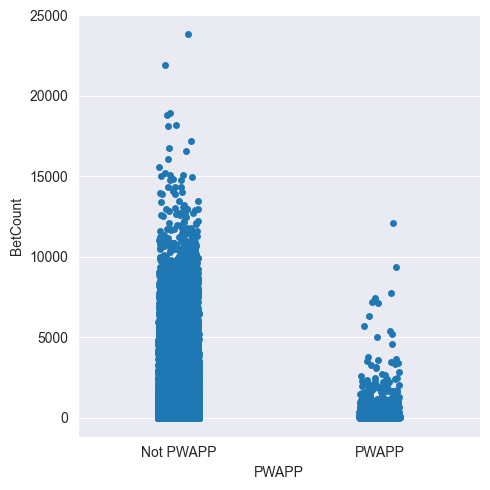

In [36]:
sns.catplot(data=frame, x='PWAPP', y="BetCount")

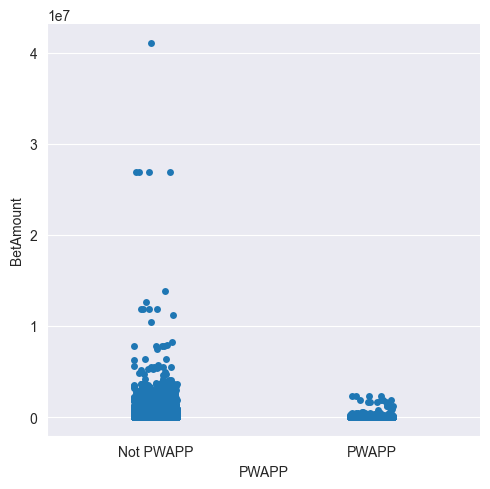

In [37]:
sns.catplot(data=frame, x='PWAPP', y="BetAmount")